<a href="https://colab.research.google.com/github/patrickctrf/IA024_2022S2/blob/main/ex10/patrick_ferreira/ex10_patrick_ferreira_175480.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook de referência 

Nome: Patrick de Carvalho Tavares Rezende Ferreira

## Instruções:

O objetivo desse colab é entender o comportamento das seguintes variáveis importantes de treinamento:
   - Batch size
   - Learning rate
   - FLOPs (computação gasta no treinamento)
   - Tamanho do modelo

Para tanto, iremos treinar e medir a loss e acurácia de 3 modelos BERT para análise de sentimento (classificação binária) usando o dataset do IMDB (20k/5k amostras de treino/validação).

Iremos fazer os 3 x 5 x 5 = 75 treinamentos, cada um usando um modelo (dentre 3), uma learning rate (dentre 5 valores) e batch size (dentro 5 valores) diferentes.

Os modelos sugeridos a serem usados são:

*   google/bert_uncased_L-2_H-128_A-2 (BERT-tiny, 4M params, ~0.5M non-embeddings)
*   google/bert_uncased_L-4_H-256_A-4 (BERT-mini, 11M params, ~3.5M non-embeddings)
*   google/bert_uncased_L-8_H-512_A-8 (BERT-medium, 41M params, ~25M non-embeddings)

Durante cada treinamento, iremos armezenar as seguntes informações: 

    - GPU usada
    - FP16 ou 32?
    - step atual
    - tempo de treinamento até então (wall time)
    - loss de treino
    - loss de validação
    - acurácia de validação
    
Iremos gravar essas informações _várias vezes por época_. Caso os treinamentos usem GPUs diferentes, podemos ajustar o wall time com base no FLOPs das GPUs.

Ao final, iremos plotar os seguintes gráficos:

1.   batch_size vs learning rate vs melhor loss de validação para cada modelo (usar gráfico 3D ou heatmap);
2.   tempo de treinamento (wall time) vs loss de validação. Plotar uma série (curva) para cada modelo, todas no mesmo gráfico. Para gerar cada curva, usar os melhores batch size e learning rate encontrados no gráfico 1. 

Com isso conseguiremos responder às seguintes perguntas:

    - Se você tiver T horas de GPU para usar, é melhor usar o modelo tiny, mini ou medium? Verifique se existe alguma faixa de valores de T em que é melhor usar o tiny. 
    - Qual modelo demora mais para atingir a sua melhor acurácia de validação em termos de épocas. E em termos de tempo de treino, wall time?
    - Para cada X vezes que aumentamos o batch size, como que devemos ajustar a learning rate?
    - Os melhores hiperparametros são parecidos para os 3 modelos?

Notas:
- Para entender melhor como batch size e learning rate se relacionam, procure fazer a varredura com passos de 5x ou 10x. Por exemplo:
    
    learning rate = {1e-2, 1e-3, ..., 1e-6}
    
    batch size = {1, 10, 100, 1000, 10000}

- Caso o batch não caiba em memória, usar acumulo de gradiente.
- Tempos estimados de treinamento para uma época do IMDB usando uma T4:
    - BERT-tiny: menos de 1 minuto
    - BERT-mini: 3 minutos
    - BERT-medium: 10 minutos. Portanto, se treinarmos por 2 épocas, o tempo total para rodar os experimentos será de `2 épocas x 10 min x 25 treinamentos ~ 9 horas`.
- Sugerimos fazer primeiro todos os experimentos com BERT-tiny e BERT-mini. Quando souber da faixa de hiperparametros "bons", não precisa fazer os 25 treinamentos para o BERT-medium.
    - TFLOPs (FP32) de cada GPU:
        T4: 8,141
        K80: 4,113
        A100: 19,49
    - Usar time.perf_counter() para medir o wall time.


In [14]:
# Check which GPU we are using
!nvidia-smi

Wed Nov  2 23:12:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   52C    P8    14W / 170W |   3816MiB / 12288MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Fixando a seed

In [2]:
import random
import re
import time

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from typing import List, Type
from tqdm.notebook import tqdm

In [3]:
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification

In [4]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

In [5]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


## Preparando Dados

Primeiro, fazemos download do dataset:

In [6]:
!wget -nc http://files.fast.ai/data/aclImdb.tgz 
!tar -xzf aclImdb.tgz

File ‘aclImdb.tgz’ already there; not retrieving.



## Carregando o dataset

Criaremos uma divisão de treino (20k exemplos) e validação (5k exemplos) artificialmente.

In [7]:
import os

max_valid = 5000

def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

x_train_pos = load_texts('aclImdb/train/pos')
x_train_neg = load_texts('aclImdb/train/neg')
x_test_pos = load_texts('aclImdb/test/pos')
x_test_neg = load_texts('aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test = x_test_pos + x_test_neg
y_train = [1] * len(x_train_pos) + [0] * len(x_train_neg)
y_test = [1] * len(x_test_pos) + [0] * len(x_test_neg)

# Embaralhamos o treino para depois fazermos a divisão treino/valid.
c = list(zip(x_train, y_train))
random.shuffle(c)
x_train, y_train = zip(*c)

x_valid = x_train[-max_valid:]
y_valid = y_train[-max_valid:]
x_train = x_train[:-max_valid]
y_train = y_train[:-max_valid]

print(len(x_train), 'amostras de treino.')
print(len(x_valid), 'amostras de desenvolvimento.')
print(len(x_test), 'amostras de teste.')

print('3 primeiras amostras treino:')
for x, y in zip(x_train[:3], y_train[:3]):
    print(y, x[:100])

print('3 últimas amostras treino:')
for x, y in zip(x_train[-3:], y_train[-3:]):
    print(y, x[:100])

print('3 primeiras amostras validação:')
for x, y in zip(x_valid[:3], y_test[:3]):
    print(y, x[:100])

print('3 últimas amostras validação:')
for x, y in zip(x_valid[-3:], y_valid[-3:]):
    print(y, x[:100])


20000 amostras de treino.
5000 amostras de desenvolvimento.
25000 amostras de teste.
3 primeiras amostras treino:
0 Barry, a medical transcriptionist has his mind corroding from his job coupled with memories of an ab
0 The movie seemed to appeal me because of the new type of Pokemon Celebi. But the plot was out of cou
1 I can't remember many films where a bumbling idiot of a hero was so funny throughout. Leslie Cheung 
3 últimas amostras treino:
0 I sat down to watch a documentary about Puerto Rico, and I ended up watching one about Nuyoricans. W
1 It's a great American martial arts movie. The fighting scenes were pretty impressive for American mo
1 The appeal of ancient films like this one is that you get to see an actual moving image of life over
3 primeiras amostras validação:
1 Why is this movie not in the 250 best? This movie looks still astoundingly fresh 56 years after its 
1 I've always believed that David and Bathsheba was a film originally intended for Tyrone Power at 20t
1 I

In [8]:
### Criando classe do dataset

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, texts: List[str], labels):
        super().__init__()

        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], torch.tensor([0., 1.]) if self.labels[idx] else torch.tensor([1., 0.])

Dados de treino, validação e teste

In [9]:
training_dataset = MyDataset(x_train, y_train)
valid_dataset = MyDataset(x_valid, y_valid)
test_dataset = MyDataset(x_test, y_test)

print(f'training examples: {len(training_dataset)}')
print(f'valid examples: {len(valid_dataset)}')
print(f'test examples: {len(test_dataset)}')

training examples: 20000
valid examples: 5000
test examples: 25000


Testando se o modelo processa os dados corretamente

In [10]:
model = tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
model.train().to(device)

sample_train, _ = next(iter(DataLoader(training_dataset, batch_size=4)))

sample_train = tokenizer.batch_encode_plus(sample_train, padding=True, return_tensors="pt", truncation=True, max_length=200).to(device)

print("model output shape: ", model(**sample_train).logits.shape)

del sample_train


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

model output shape:  torch.Size([4, 2])


TREINAMENTO

In [11]:
from torch.cuda.amp import GradScaler, autocast

use_amp = True

n_grads_accumulated = 0
accumulate = 8

def train_step(input_ids, target_ids):
    model.train()
    with autocast(enabled=use_amp):
        logits = model(**input_ids).logits
        logits = logits.reshape(-1, logits.shape[-1])
    loss = nn.functional.cross_entropy(logits, target_ids, )
    scaler.scale(loss).backward()
    if n_grads_accumulated % accumulate == 0:
        scaler.step(optimizer)
        scaler.update()
        model.zero_grad()

    return loss.item()


def validation_step(input_ids, target_ids):
    model.eval()
    with autocast(enabled=use_amp):
        logits = model(**input_ids).logits
        loss = nn.functional.cross_entropy(logits, target_ids,)
        preds = logits.argmax(dim=1)
        accuracy = (preds == target_ids.argmax(dim=1)).sum().float() / logits.shape[0]
    return loss.item(), accuracy.item()

epochs = 2
max_examples = int(len(training_dataset) * epochs)

rtx3060_tflops = 12.74 # https://www.techpowerup.com/gpu-specs/geforce-rtx-3060.c3682

model_list = ["google/bert_uncased_L-2_H-128_A-2",
              "google/bert_uncased_L-4_H-256_A-4",
              "google/bert_uncased_L-8_H-512_A-8",][::-1]
batch_sizes = [8, 16, 32, 64, 128, 256][::-1]
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

log_df = pd.DataFrame.from_dict({
    "model_name": [],
    "batch_size": [],
    "lr": [],
    "val_loss": [],
    "best_acc": [],
    "wall_time": []
})

for model_name in tqdm(model_list):
    for batch_size in batch_sizes:
        for lr in learning_rates:
            model_identifier = model_name + "_batch_size_" + str(batch_size) + "_lr_" + str(lr)
            print("Current Setup: ", model_identifier)

            model = BertForSequenceClassification.from_pretrained(model_name)
            model.train().to(device)

            eval_every_steps = 984 * 64// batch_size

            train_loader = DataLoader(training_dataset, batch_size=batch_size//accumulate, shuffle=True, num_workers=1)
            validation_loader = DataLoader(valid_dataset, batch_size=batch_size//accumulate, num_workers=1, )

            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            scaler=GradScaler()

            best_validation_loss = 9999
            best_validation_acc = 0
            convergence_time = 0
            train_losses = []
            n_examples = 0
            step = 0
            pbar = tqdm(total=max_examples)
            start_time = time.time()
            while n_examples < max_examples:
                n_grads_accumulated = 0
                val_losses = []
                wall_times = []
                for train_input_ids, train_target_ids in train_loader:
                    train_input_ids = tokenizer.batch_encode_plus(train_input_ids, padding=True, return_tensors="pt", truncation=True, max_length=200).to(device)
                    n_grads_accumulated = n_grads_accumulated + 1
                    loss = train_step(train_input_ids, train_target_ids.to(device))
                    train_losses.append(loss)

                    if step % eval_every_steps == 0:
                        train_loss = np.average(train_losses)

                        with torch.no_grad():
                            valid_result = list(zip(*[
                                validation_step(tokenizer.batch_encode_plus(val_input_ids, padding=True, return_tensors="pt", truncation=True, max_length=200).to(device), val_target_ids.to(device))
                                for val_input_ids, val_target_ids in validation_loader]))
                            valid_loss = np.average(valid_result[0])
                            valid_acc = np.average(valid_result[1])
                            # Checkpoint to best models found.
                            if best_validation_loss > valid_loss:
                                # Update the new best perplexity.
                                best_validation_loss = valid_loss
                                best_validation_acc = valid_acc
                                convergence_time = time.time() - start_time

                        val_losses.append(valid_loss)
                        wall_times.append((time.time()-start_time) * rtx3060_tflops)
                        print(f'{step} steps; {n_examples} examples so far; train loss: {train_loss:.2f}, valid loss: {valid_loss:.2f}')
                        train_losses = []

                    n_examples += train_input_ids.input_ids.shape[0] # Increment of batch size
                    step += 1
                    pbar.update(train_input_ids.input_ids.shape[0])
                    if n_examples >= max_examples:
                        break

            log_df = log_df.append({
                "model_name": model_name,
                "batch_size": batch_size,
                "lr": lr,
                "val_loss": best_validation_loss,
                "best_acc": best_validation_acc,
                "wall_time": convergence_time * rtx3060_tflops,
                "losses_list": val_losses,
                "times": wall_times,
            }, ignore_index=True)

            pbar.close()

  0%|          | 0/3 [00:00<?, ?it/s]

Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_256_lr_0.01


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.73, valid loss: 0.73
246 steps; 7872 examples so far; train loss: 1.50, valid loss: 0.73
492 steps; 15744 examples so far; train loss: 0.73, valid loss: 0.70
738 steps; 23616 examples so far; train loss: 0.71, valid loss: 0.71
984 steps; 31488 examples so far; train loss: 0.71, valid loss: 0.69
1230 steps; 39360 examples so far; train loss: 0.71, valid loss: 0.73


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_256_lr_0.001


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.78, valid loss: 0.73
246 steps; 7872 examples so far; train loss: 0.75, valid loss: 0.70
492 steps; 15744 examples so far; train loss: 0.70, valid loss: 0.70
738 steps; 23616 examples so far; train loss: 0.70, valid loss: 0.69
984 steps; 31488 examples so far; train loss: 0.70, valid loss: 0.70
1230 steps; 39360 examples so far; train loss: 0.70, valid loss: 0.70


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_256_lr_0.0001


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.77, valid loss: 0.74
246 steps; 7872 examples so far; train loss: 0.50, valid loss: 0.35
492 steps; 15744 examples so far; train loss: 0.33, valid loss: 0.31
738 steps; 23616 examples so far; train loss: 0.26, valid loss: 0.31
984 steps; 31488 examples so far; train loss: 0.21, valid loss: 0.33
1230 steps; 39360 examples so far; train loss: 0.23, valid loss: 0.31


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_256_lr_1e-05


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.72, valid loss: 0.71
246 steps; 7872 examples so far; train loss: 0.63, valid loss: 0.53
492 steps; 15744 examples so far; train loss: 0.47, valid loss: 0.39
738 steps; 23616 examples so far; train loss: 0.37, valid loss: 0.35
984 steps; 31488 examples so far; train loss: 0.33, valid loss: 0.33
1230 steps; 39360 examples so far; train loss: 0.32, valid loss: 0.32


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_256_lr_1e-06


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.73, valid loss: 0.74
246 steps; 7872 examples so far; train loss: 0.71, valid loss: 0.69
492 steps; 15744 examples so far; train loss: 0.69, valid loss: 0.67
738 steps; 23616 examples so far; train loss: 0.67, valid loss: 0.66
984 steps; 31488 examples so far; train loss: 0.65, valid loss: 0.64
1230 steps; 39360 examples so far; train loss: 0.64, valid loss: 0.62


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_128_lr_0.01


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.69, valid loss: 0.70
492 steps; 7872 examples so far; train loss: 0.87, valid loss: 0.78
984 steps; 15744 examples so far; train loss: 0.75, valid loss: 0.71
1476 steps; 23616 examples so far; train loss: 0.74, valid loss: 0.70
1968 steps; 31488 examples so far; train loss: 0.80, valid loss: 0.73
2460 steps; 39360 examples so far; train loss: 0.74, valid loss: 0.69


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_128_lr_0.001


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.74, valid loss: 0.71
492 steps; 7872 examples so far; train loss: 0.72, valid loss: 0.70
984 steps; 15744 examples so far; train loss: 0.70, valid loss: 0.69
1476 steps; 23616 examples so far; train loss: 0.70, valid loss: 0.70
1968 steps; 31488 examples so far; train loss: 0.70, valid loss: 0.71
2460 steps; 39360 examples so far; train loss: 0.70, valid loss: 0.73


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_128_lr_0.0001


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.70, valid loss: 0.70
492 steps; 7872 examples so far; train loss: 0.42, valid loss: 0.33
984 steps; 15744 examples so far; train loss: 0.31, valid loss: 0.30
1476 steps; 23616 examples so far; train loss: 0.25, valid loss: 0.33
1968 steps; 31488 examples so far; train loss: 0.20, valid loss: 0.31
2460 steps; 39360 examples so far; train loss: 0.22, valid loss: 0.36


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_128_lr_1e-05


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.68, valid loss: 0.70
492 steps; 7872 examples so far; train loss: 0.57, valid loss: 0.40
984 steps; 15744 examples so far; train loss: 0.38, valid loss: 0.34
1476 steps; 23616 examples so far; train loss: 0.33, valid loss: 0.32
1968 steps; 31488 examples so far; train loss: 0.31, valid loss: 0.32
2460 steps; 39360 examples so far; train loss: 0.29, valid loss: 0.30


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_128_lr_1e-06


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.79, valid loss: 0.72
492 steps; 7872 examples so far; train loss: 0.69, valid loss: 0.67
984 steps; 15744 examples so far; train loss: 0.66, valid loss: 0.64
1476 steps; 23616 examples so far; train loss: 0.63, valid loss: 0.61
1968 steps; 31488 examples so far; train loss: 0.60, valid loss: 0.57
2460 steps; 39360 examples so far; train loss: 0.55, valid loss: 0.52


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_64_lr_0.01


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.78, valid loss: 0.69
984 steps; 7872 examples so far; train loss: 0.86, valid loss: 0.85
1968 steps; 15744 examples so far; train loss: 0.78, valid loss: 0.69
2952 steps; 23616 examples so far; train loss: 0.79, valid loss: 0.84
3936 steps; 31488 examples so far; train loss: 0.74, valid loss: 0.71
4920 steps; 39360 examples so far; train loss: 0.79, valid loss: 0.79


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_64_lr_0.001


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.58, valid loss: 0.73
984 steps; 7872 examples so far; train loss: 0.73, valid loss: 0.72
1968 steps; 15744 examples so far; train loss: 0.71, valid loss: 0.70
2952 steps; 23616 examples so far; train loss: 0.71, valid loss: 0.70
3936 steps; 31488 examples so far; train loss: 0.70, valid loss: 0.69
4920 steps; 39360 examples so far; train loss: 0.71, valid loss: 0.69


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_64_lr_0.0001


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.68, valid loss: 0.71
984 steps; 7872 examples so far; train loss: 0.40, valid loss: 0.34
1968 steps; 15744 examples so far; train loss: 0.31, valid loss: 0.32
2952 steps; 23616 examples so far; train loss: 0.25, valid loss: 0.36
3936 steps; 31488 examples so far; train loss: 0.19, valid loss: 0.33
4920 steps; 39360 examples so far; train loss: 0.22, valid loss: 0.31


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_64_lr_1e-05


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.64, valid loss: 0.71
984 steps; 7872 examples so far; train loss: 0.50, valid loss: 0.36
1968 steps; 15744 examples so far; train loss: 0.37, valid loss: 0.32
2952 steps; 23616 examples so far; train loss: 0.31, valid loss: 0.31
3936 steps; 31488 examples so far; train loss: 0.29, valid loss: 0.30
4920 steps; 39360 examples so far; train loss: 0.27, valid loss: 0.29


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_64_lr_1e-06


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.97, valid loss: 0.78
984 steps; 7872 examples so far; train loss: 0.71, valid loss: 0.68
1968 steps; 15744 examples so far; train loss: 0.67, valid loss: 0.65
2952 steps; 23616 examples so far; train loss: 0.63, valid loss: 0.60
3936 steps; 31488 examples so far; train loss: 0.57, valid loss: 0.52
4920 steps; 39360 examples so far; train loss: 0.50, valid loss: 0.45


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_32_lr_0.01


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.79, valid loss: 0.71
1968 steps; 7872 examples so far; train loss: 0.86, valid loss: 0.79
3936 steps; 15744 examples so far; train loss: 0.87, valid loss: 0.76
5904 steps; 23616 examples so far; train loss: 0.85, valid loss: 1.41
7872 steps; 31488 examples so far; train loss: 0.84, valid loss: 0.70
9840 steps; 39360 examples so far; train loss: 0.81, valid loss: 0.73


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_32_lr_0.001


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.84, valid loss: 0.71
1968 steps; 7872 examples so far; train loss: 0.72, valid loss: 0.70
3936 steps; 15744 examples so far; train loss: 0.71, valid loss: 0.69
5904 steps; 23616 examples so far; train loss: 0.72, valid loss: 0.69
7872 steps; 31488 examples so far; train loss: 0.71, valid loss: 0.72
9840 steps; 39360 examples so far; train loss: 0.71, valid loss: 0.69


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_32_lr_0.0001


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.63, valid loss: 0.69
1968 steps; 7872 examples so far; train loss: 0.42, valid loss: 0.34
3936 steps; 15744 examples so far; train loss: 0.33, valid loss: 0.35
5904 steps; 23616 examples so far; train loss: 0.28, valid loss: 0.33
7872 steps; 31488 examples so far; train loss: 0.22, valid loss: 0.35
9840 steps; 39360 examples so far; train loss: 0.21, valid loss: 0.40


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_32_lr_1e-05


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.89, valid loss: 0.72
1968 steps; 7872 examples so far; train loss: 0.45, valid loss: 0.34
3936 steps; 15744 examples so far; train loss: 0.34, valid loss: 0.31
5904 steps; 23616 examples so far; train loss: 0.29, valid loss: 0.33
7872 steps; 31488 examples so far; train loss: 0.27, valid loss: 0.30
9840 steps; 39360 examples so far; train loss: 0.26, valid loss: 0.29


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_32_lr_1e-06


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.61, valid loss: 0.69
1968 steps; 7872 examples so far; train loss: 0.66, valid loss: 0.61
3936 steps; 15744 examples so far; train loss: 0.56, valid loss: 0.48
5904 steps; 23616 examples so far; train loss: 0.45, valid loss: 0.41
7872 steps; 31488 examples so far; train loss: 0.40, valid loss: 0.38
9840 steps; 39360 examples so far; train loss: 0.37, valid loss: 0.36


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_16_lr_0.01


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.89, valid loss: 0.70
3936 steps; 7872 examples so far; train loss: 0.90, valid loss: 0.81
7872 steps; 15744 examples so far; train loss: 0.90, valid loss: 1.02
11808 steps; 23616 examples so far; train loss: 0.92, valid loss: 0.80
15744 steps; 31488 examples so far; train loss: 0.89, valid loss: 1.05
19680 steps; 39360 examples so far; train loss: 0.95, valid loss: 0.84


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_16_lr_0.001


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.61, valid loss: 0.70
3936 steps; 7872 examples so far; train loss: 0.72, valid loss: 0.69
7872 steps; 15744 examples so far; train loss: 0.72, valid loss: 0.80
11808 steps; 23616 examples so far; train loss: 0.71, valid loss: 0.70
15744 steps; 31488 examples so far; train loss: 0.72, valid loss: 0.70
19680 steps; 39360 examples so far; train loss: 0.71, valid loss: 0.69


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_16_lr_0.0001


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.85, valid loss: 0.77
3936 steps; 7872 examples so far; train loss: 0.44, valid loss: 0.36
7872 steps; 15744 examples so far; train loss: 0.35, valid loss: 0.37
11808 steps; 23616 examples so far; train loss: 0.30, valid loss: 0.41
15744 steps; 31488 examples so far; train loss: 0.25, valid loss: 0.40
19680 steps; 39360 examples so far; train loss: 0.25, valid loss: 0.32


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_16_lr_1e-05


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.71, valid loss: 0.69
3936 steps; 7872 examples so far; train loss: 0.44, valid loss: 0.35
7872 steps; 15744 examples so far; train loss: 0.32, valid loss: 0.32
11808 steps; 23616 examples so far; train loss: 0.28, valid loss: 0.29
15744 steps; 31488 examples so far; train loss: 0.24, valid loss: 0.32
19680 steps; 39360 examples so far; train loss: 0.25, valid loss: 0.31


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_16_lr_1e-06


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.55, valid loss: 0.73
3936 steps; 7872 examples so far; train loss: 0.66, valid loss: 0.59
7872 steps; 15744 examples so far; train loss: 0.53, valid loss: 0.45
11808 steps; 23616 examples so far; train loss: 0.42, valid loss: 0.38
15744 steps; 31488 examples so far; train loss: 0.38, valid loss: 0.36
19680 steps; 39360 examples so far; train loss: 0.35, valid loss: 0.35


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_8_lr_0.01


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.62, valid loss: 0.69
7872 steps; 7872 examples so far; train loss: 1.04, valid loss: 0.77
15744 steps; 15744 examples so far; train loss: 1.05, valid loss: 2.12
23616 steps; 23616 examples so far; train loss: 1.00, valid loss: 0.81
31488 steps; 31488 examples so far; train loss: 1.10, valid loss: 1.12
39360 steps; 39360 examples so far; train loss: 1.04, valid loss: 0.69


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_8_lr_0.001


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 1.14, valid loss: 0.76
7872 steps; 7872 examples so far; train loss: 0.73, valid loss: 0.77
15744 steps; 15744 examples so far; train loss: 0.73, valid loss: 0.71
23616 steps; 23616 examples so far; train loss: 0.73, valid loss: 0.70
31488 steps; 31488 examples so far; train loss: 0.73, valid loss: 0.70
39360 steps; 39360 examples so far; train loss: 0.73, valid loss: 0.69


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_8_lr_0.0001


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.71, valid loss: 0.69
7872 steps; 7872 examples so far; train loss: 0.63, valid loss: 0.69
15744 steps; 15744 examples so far; train loss: 0.70, valid loss: 0.71
23616 steps; 23616 examples so far; train loss: 0.70, valid loss: 0.69
31488 steps; 31488 examples so far; train loss: 0.70, valid loss: 0.70
39360 steps; 39360 examples so far; train loss: 0.70, valid loss: 0.70


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_8_lr_1e-05


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.56, valid loss: 0.70
7872 steps; 7872 examples so far; train loss: 0.41, valid loss: 0.31
15744 steps; 15744 examples so far; train loss: 0.32, valid loss: 0.30
23616 steps; 23616 examples so far; train loss: 0.27, valid loss: 0.30
31488 steps; 31488 examples so far; train loss: 0.23, valid loss: 0.29
39360 steps; 39360 examples so far; train loss: 0.23, valid loss: 0.30


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-8_H-512_A-8_batch_size_8_lr_1e-06


Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.57, valid loss: 0.71
7872 steps; 7872 examples so far; train loss: 0.62, valid loss: 0.53
15744 steps; 15744 examples so far; train loss: 0.46, valid loss: 0.39
23616 steps; 23616 examples so far; train loss: 0.39, valid loss: 0.36
31488 steps; 31488 examples so far; train loss: 0.35, valid loss: 0.35
39360 steps; 39360 examples so far; train loss: 0.35, valid loss: 0.34


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_256_lr_0.01


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.70, valid loss: 0.71
246 steps; 7872 examples so far; train loss: 0.84, valid loss: 0.69
492 steps; 15744 examples so far; train loss: 0.72, valid loss: 0.70
738 steps; 23616 examples so far; train loss: 0.72, valid loss: 0.71
984 steps; 31488 examples so far; train loss: 0.71, valid loss: 0.70
1230 steps; 39360 examples so far; train loss: 0.71, valid loss: 0.70


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_256_lr_0.001


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.71, valid loss: 0.69
246 steps; 7872 examples so far; train loss: 0.70, valid loss: 0.61
492 steps; 15744 examples so far; train loss: 0.48, valid loss: 0.40
738 steps; 23616 examples so far; train loss: 0.37, valid loss: 0.38
984 steps; 31488 examples so far; train loss: 0.32, valid loss: 0.36
1230 steps; 39360 examples so far; train loss: 0.30, valid loss: 0.35


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_256_lr_0.0001


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.82, valid loss: 0.72
246 steps; 7872 examples so far; train loss: 0.60, valid loss: 0.47
492 steps; 15744 examples so far; train loss: 0.41, valid loss: 0.36
738 steps; 23616 examples so far; train loss: 0.35, valid loss: 0.35
984 steps; 31488 examples so far; train loss: 0.30, valid loss: 0.35
1230 steps; 39360 examples so far; train loss: 0.30, valid loss: 0.33


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_256_lr_1e-05


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.69, valid loss: 0.69
246 steps; 7872 examples so far; train loss: 0.67, valid loss: 0.65
492 steps; 15744 examples so far; train loss: 0.64, valid loss: 0.61
738 steps; 23616 examples so far; train loss: 0.59, valid loss: 0.56
984 steps; 31488 examples so far; train loss: 0.53, valid loss: 0.50
1230 steps; 39360 examples so far; train loss: 0.49, valid loss: 0.46


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_256_lr_1e-06


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.83, valid loss: 0.77
246 steps; 7872 examples so far; train loss: 0.75, valid loss: 0.73
492 steps; 15744 examples so far; train loss: 0.72, valid loss: 0.70
738 steps; 23616 examples so far; train loss: 0.70, valid loss: 0.69
984 steps; 31488 examples so far; train loss: 0.69, valid loss: 0.69
1230 steps; 39360 examples so far; train loss: 0.68, valid loss: 0.68


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_128_lr_0.01


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.65, valid loss: 0.70
492 steps; 7872 examples so far; train loss: 0.75, valid loss: 0.69
984 steps; 15744 examples so far; train loss: 0.72, valid loss: 0.73
1476 steps; 23616 examples so far; train loss: 0.74, valid loss: 0.72
1968 steps; 31488 examples so far; train loss: 0.72, valid loss: 0.76
2460 steps; 39360 examples so far; train loss: 0.74, valid loss: 0.70


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_128_lr_0.001


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.70, valid loss: 0.71
492 steps; 7872 examples so far; train loss: 0.66, valid loss: 0.54
984 steps; 15744 examples so far; train loss: 0.46, valid loss: 0.41
1476 steps; 23616 examples so far; train loss: 0.37, valid loss: 0.38
1968 steps; 31488 examples so far; train loss: 0.32, valid loss: 0.54
2460 steps; 39360 examples so far; train loss: 0.36, valid loss: 0.40


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_128_lr_0.0001


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.68, valid loss: 0.69
492 steps; 7872 examples so far; train loss: 0.56, valid loss: 0.42
984 steps; 15744 examples so far; train loss: 0.40, valid loss: 0.36
1476 steps; 23616 examples so far; train loss: 0.33, valid loss: 0.35
1968 steps; 31488 examples so far; train loss: 0.28, valid loss: 0.34
2460 steps; 39360 examples so far; train loss: 0.28, valid loss: 0.32


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_128_lr_1e-05


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.73, valid loss: 0.72
492 steps; 7872 examples so far; train loss: 0.67, valid loss: 0.64
984 steps; 15744 examples so far; train loss: 0.61, valid loss: 0.56
1476 steps; 23616 examples so far; train loss: 0.52, valid loss: 0.47
1968 steps; 31488 examples so far; train loss: 0.46, valid loss: 0.42
2460 steps; 39360 examples so far; train loss: 0.41, valid loss: 0.40


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_128_lr_1e-06


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.71, valid loss: 0.70
492 steps; 7872 examples so far; train loss: 0.69, valid loss: 0.69
984 steps; 15744 examples so far; train loss: 0.69, valid loss: 0.68
1476 steps; 23616 examples so far; train loss: 0.68, valid loss: 0.67
1968 steps; 31488 examples so far; train loss: 0.67, valid loss: 0.66
2460 steps; 39360 examples so far; train loss: 0.67, valid loss: 0.66


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_64_lr_0.01


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.97, valid loss: 0.82
984 steps; 7872 examples so far; train loss: 0.78, valid loss: 0.70
1968 steps; 15744 examples so far; train loss: 0.73, valid loss: 0.70
2952 steps; 23616 examples so far; train loss: 0.72, valid loss: 0.73
3936 steps; 31488 examples so far; train loss: 0.76, valid loss: 0.76
4920 steps; 39360 examples so far; train loss: 0.74, valid loss: 0.70


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_64_lr_0.001


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.75, valid loss: 0.69
984 steps; 7872 examples so far; train loss: 0.61, valid loss: 0.61
1968 steps; 15744 examples so far; train loss: 0.65, valid loss: 0.66
2952 steps; 23616 examples so far; train loss: 0.68, valid loss: 0.69
3936 steps; 31488 examples so far; train loss: 0.70, valid loss: 0.70
4920 steps; 39360 examples so far; train loss: 0.70, valid loss: 0.69


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_64_lr_0.0001


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.66, valid loss: 0.69
984 steps; 7872 examples so far; train loss: 0.48, valid loss: 0.37
1968 steps; 15744 examples so far; train loss: 0.37, valid loss: 0.35
2952 steps; 23616 examples so far; train loss: 0.30, valid loss: 0.34
3936 steps; 31488 examples so far; train loss: 0.27, valid loss: 0.33
4920 steps; 39360 examples so far; train loss: 0.26, valid loss: 0.30


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_64_lr_1e-05


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.70, valid loss: 0.70
984 steps; 7872 examples so far; train loss: 0.65, valid loss: 0.58
1968 steps; 15744 examples so far; train loss: 0.53, valid loss: 0.46
2952 steps; 23616 examples so far; train loss: 0.44, valid loss: 0.41
3936 steps; 31488 examples so far; train loss: 0.39, valid loss: 0.39
4920 steps; 39360 examples so far; train loss: 0.38, valid loss: 0.37


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_64_lr_1e-06


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.81, valid loss: 0.73
984 steps; 7872 examples so far; train loss: 0.70, valid loss: 0.68
1968 steps; 15744 examples so far; train loss: 0.68, valid loss: 0.67
2952 steps; 23616 examples so far; train loss: 0.67, valid loss: 0.66
3936 steps; 31488 examples so far; train loss: 0.66, valid loss: 0.65
4920 steps; 39360 examples so far; train loss: 0.65, valid loss: 0.64


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_32_lr_0.01


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.75, valid loss: 0.70
1968 steps; 7872 examples so far; train loss: 0.77, valid loss: 0.78
3936 steps; 15744 examples so far; train loss: 0.79, valid loss: 0.70
5904 steps; 23616 examples so far; train loss: 0.76, valid loss: 0.85
7872 steps; 31488 examples so far; train loss: 0.78, valid loss: 0.69
9840 steps; 39360 examples so far; train loss: 0.75, valid loss: 0.86


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_32_lr_0.001


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.72, valid loss: 0.69
1968 steps; 7872 examples so far; train loss: 0.70, valid loss: 0.69
3936 steps; 15744 examples so far; train loss: 0.70, valid loss: 0.70
5904 steps; 23616 examples so far; train loss: 0.70, valid loss: 0.69
7872 steps; 31488 examples so far; train loss: 0.70, valid loss: 0.70
9840 steps; 39360 examples so far; train loss: 0.70, valid loss: 0.71


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_32_lr_0.0001


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.76, valid loss: 0.77
1968 steps; 7872 examples so far; train loss: 0.47, valid loss: 0.41
3936 steps; 15744 examples so far; train loss: 0.36, valid loss: 0.44
5904 steps; 23616 examples so far; train loss: 0.31, valid loss: 0.36
7872 steps; 31488 examples so far; train loss: 0.25, valid loss: 0.36
9840 steps; 39360 examples so far; train loss: 0.26, valid loss: 0.31


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_32_lr_1e-05


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.68, valid loss: 0.70
1968 steps; 7872 examples so far; train loss: 0.63, valid loss: 0.53
3936 steps; 15744 examples so far; train loss: 0.49, valid loss: 0.43
5904 steps; 23616 examples so far; train loss: 0.40, valid loss: 0.41
7872 steps; 31488 examples so far; train loss: 0.38, valid loss: 0.36
9840 steps; 39360 examples so far; train loss: 0.35, valid loss: 0.35


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_32_lr_1e-06


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.79, valid loss: 0.70
1968 steps; 7872 examples so far; train loss: 0.69, valid loss: 0.68
3936 steps; 15744 examples so far; train loss: 0.68, valid loss: 0.67
5904 steps; 23616 examples so far; train loss: 0.67, valid loss: 0.65
7872 steps; 31488 examples so far; train loss: 0.65, valid loss: 0.64
9840 steps; 39360 examples so far; train loss: 0.63, valid loss: 0.61


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_16_lr_0.01


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.64, valid loss: 0.70
3936 steps; 7872 examples so far; train loss: 0.81, valid loss: 0.86
7872 steps; 15744 examples so far; train loss: 0.80, valid loss: 0.69
11808 steps; 23616 examples so far; train loss: 0.81, valid loss: 0.73
15744 steps; 31488 examples so far; train loss: 0.80, valid loss: 0.79
19680 steps; 39360 examples so far; train loss: 0.83, valid loss: 0.71


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_16_lr_0.001


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.83, valid loss: 0.73
3936 steps; 7872 examples so far; train loss: 0.71, valid loss: 0.72
7872 steps; 15744 examples so far; train loss: 0.71, valid loss: 0.69
11808 steps; 23616 examples so far; train loss: 0.70, valid loss: 0.71
15744 steps; 31488 examples so far; train loss: 0.70, valid loss: 0.70
19680 steps; 39360 examples so far; train loss: 0.71, valid loss: 0.69


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_16_lr_0.0001


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.69, valid loss: 0.70
3936 steps; 7872 examples so far; train loss: 0.46, valid loss: 0.36
7872 steps; 15744 examples so far; train loss: 0.36, valid loss: 0.36
11808 steps; 23616 examples so far; train loss: 0.29, valid loss: 0.33
15744 steps; 31488 examples so far; train loss: 0.24, valid loss: 0.33
19680 steps; 39360 examples so far; train loss: 0.24, valid loss: 0.36


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_16_lr_1e-05


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.77, valid loss: 0.69
3936 steps; 7872 examples so far; train loss: 0.59, valid loss: 0.45
7872 steps; 15744 examples so far; train loss: 0.41, valid loss: 0.38
11808 steps; 23616 examples so far; train loss: 0.38, valid loss: 0.37
15744 steps; 31488 examples so far; train loss: 0.34, valid loss: 0.35
19680 steps; 39360 examples so far; train loss: 0.34, valid loss: 0.34


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_16_lr_1e-06


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.50, valid loss: 0.72
3936 steps; 7872 examples so far; train loss: 0.69, valid loss: 0.67
7872 steps; 15744 examples so far; train loss: 0.66, valid loss: 0.65
11808 steps; 23616 examples so far; train loss: 0.64, valid loss: 0.62
15744 steps; 31488 examples so far; train loss: 0.62, valid loss: 0.60
19680 steps; 39360 examples so far; train loss: 0.59, valid loss: 0.58


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_8_lr_0.01


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.81, valid loss: 0.70
7872 steps; 7872 examples so far; train loss: 0.90, valid loss: 0.85
15744 steps; 15744 examples so far; train loss: 0.88, valid loss: 1.93
23616 steps; 23616 examples so far; train loss: 0.88, valid loss: 0.85
31488 steps; 31488 examples so far; train loss: 0.86, valid loss: 0.72
39360 steps; 39360 examples so far; train loss: 0.87, valid loss: 0.97


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_8_lr_0.001


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 1.12, valid loss: 0.76
7872 steps; 7872 examples so far; train loss: 0.71, valid loss: 0.70
15744 steps; 15744 examples so far; train loss: 0.71, valid loss: 0.70
23616 steps; 23616 examples so far; train loss: 0.70, valid loss: 0.69
31488 steps; 31488 examples so far; train loss: 0.70, valid loss: 0.70
39360 steps; 39360 examples so far; train loss: 0.70, valid loss: 0.69


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_8_lr_0.0001


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.96, valid loss: 0.72
7872 steps; 7872 examples so far; train loss: 0.46, valid loss: 0.39
15744 steps; 15744 examples so far; train loss: 0.36, valid loss: 0.35
23616 steps; 23616 examples so far; train loss: 0.30, valid loss: 0.33
31488 steps; 31488 examples so far; train loss: 0.22, valid loss: 0.33
39360 steps; 39360 examples so far; train loss: 0.23, valid loss: 0.35


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_8_lr_1e-05


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.81, valid loss: 0.71
7872 steps; 7872 examples so far; train loss: 0.54, valid loss: 0.41
15744 steps; 15744 examples so far; train loss: 0.39, valid loss: 0.37
23616 steps; 23616 examples so far; train loss: 0.37, valid loss: 0.35
31488 steps; 31488 examples so far; train loss: 0.33, valid loss: 0.35
39360 steps; 39360 examples so far; train loss: 0.32, valid loss: 0.33


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-4_H-256_A-4_batch_size_8_lr_1e-06


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.60, valid loss: 0.70
7872 steps; 7872 examples so far; train loss: 0.68, valid loss: 0.66
15744 steps; 15744 examples so far; train loss: 0.65, valid loss: 0.64
23616 steps; 23616 examples so far; train loss: 0.63, valid loss: 0.61
31488 steps; 31488 examples so far; train loss: 0.60, valid loss: 0.57
39360 steps; 39360 examples so far; train loss: 0.56, valid loss: 0.53


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_256_lr_0.01


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.68, valid loss: 0.70
246 steps; 7872 examples so far; train loss: 0.72, valid loss: 0.70
492 steps; 15744 examples so far; train loss: 0.71, valid loss: 0.70
738 steps; 23616 examples so far; train loss: 0.70, valid loss: 0.69
984 steps; 31488 examples so far; train loss: 0.70, valid loss: 0.70
1230 steps; 39360 examples so far; train loss: 0.71, valid loss: 0.70


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_256_lr_0.001


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.73, valid loss: 0.70
246 steps; 7872 examples so far; train loss: 0.67, valid loss: 0.53
492 steps; 15744 examples so far; train loss: 0.46, valid loss: 0.37
738 steps; 23616 examples so far; train loss: 0.31, valid loss: 0.38
984 steps; 31488 examples so far; train loss: 0.26, valid loss: 0.39
1230 steps; 39360 examples so far; train loss: 0.26, valid loss: 0.34


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_256_lr_0.0001


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.70, valid loss: 0.72
246 steps; 7872 examples so far; train loss: 0.68, valid loss: 0.65
492 steps; 15744 examples so far; train loss: 0.60, valid loss: 0.53
738 steps; 23616 examples so far; train loss: 0.48, valid loss: 0.47
984 steps; 31488 examples so far; train loss: 0.40, valid loss: 0.43
1230 steps; 39360 examples so far; train loss: 0.38, valid loss: 0.37


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_256_lr_1e-05


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.69, valid loss: 0.70
246 steps; 7872 examples so far; train loss: 0.69, valid loss: 0.69
492 steps; 15744 examples so far; train loss: 0.68, valid loss: 0.68
738 steps; 23616 examples so far; train loss: 0.67, valid loss: 0.67
984 steps; 31488 examples so far; train loss: 0.66, valid loss: 0.66
1230 steps; 39360 examples so far; train loss: 0.66, valid loss: 0.65


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_256_lr_1e-06


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.68, valid loss: 0.69
246 steps; 7872 examples so far; train loss: 0.69, valid loss: 0.69
492 steps; 15744 examples so far; train loss: 0.69, valid loss: 0.69
738 steps; 23616 examples so far; train loss: 0.69, valid loss: 0.69
984 steps; 31488 examples so far; train loss: 0.69, valid loss: 0.69
1230 steps; 39360 examples so far; train loss: 0.69, valid loss: 0.69


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_128_lr_0.01


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.66, valid loss: 0.69
492 steps; 7872 examples so far; train loss: 0.73, valid loss: 0.69
984 steps; 15744 examples so far; train loss: 0.72, valid loss: 0.73
1476 steps; 23616 examples so far; train loss: 0.71, valid loss: 0.70
1968 steps; 31488 examples so far; train loss: 0.70, valid loss: 0.73
2460 steps; 39360 examples so far; train loss: 0.70, valid loss: 0.70


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_128_lr_0.001


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.67, valid loss: 0.71
492 steps; 7872 examples so far; train loss: 0.53, valid loss: 0.40
984 steps; 15744 examples so far; train loss: 0.42, valid loss: 0.42
1476 steps; 23616 examples so far; train loss: 0.33, valid loss: 0.35
1968 steps; 31488 examples so far; train loss: 0.25, valid loss: 0.35
2460 steps; 39360 examples so far; train loss: 0.27, valid loss: 0.35


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_128_lr_0.0001


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.71, valid loss: 0.70
492 steps; 7872 examples so far; train loss: 0.64, valid loss: 0.56
984 steps; 15744 examples so far; train loss: 0.49, valid loss: 0.42
1476 steps; 23616 examples so far; train loss: 0.39, valid loss: 0.39
1968 steps; 31488 examples so far; train loss: 0.37, valid loss: 0.37
2460 steps; 39360 examples so far; train loss: 0.33, valid loss: 0.36


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_128_lr_1e-05


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.73, valid loss: 0.71
492 steps; 7872 examples so far; train loss: 0.70, valid loss: 0.68
984 steps; 15744 examples so far; train loss: 0.68, valid loss: 0.67
1476 steps; 23616 examples so far; train loss: 0.66, valid loss: 0.65
1968 steps; 31488 examples so far; train loss: 0.65, valid loss: 0.63
2460 steps; 39360 examples so far; train loss: 0.63, valid loss: 0.61


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_128_lr_1e-06


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.69, valid loss: 0.72
492 steps; 7872 examples so far; train loss: 0.72, valid loss: 0.71
984 steps; 15744 examples so far; train loss: 0.71, valid loss: 0.71
1476 steps; 23616 examples so far; train loss: 0.71, valid loss: 0.70
1968 steps; 31488 examples so far; train loss: 0.71, valid loss: 0.70
2460 steps; 39360 examples so far; train loss: 0.70, valid loss: 0.70


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_64_lr_0.01


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.78, valid loss: 0.72
984 steps; 7872 examples so far; train loss: 0.72, valid loss: 0.72
1968 steps; 15744 examples so far; train loss: 0.71, valid loss: 0.79
2952 steps; 23616 examples so far; train loss: 0.72, valid loss: 0.69
3936 steps; 31488 examples so far; train loss: 0.72, valid loss: 0.70
4920 steps; 39360 examples so far; train loss: 0.72, valid loss: 0.71


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_64_lr_0.001


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.70, valid loss: 0.69
984 steps; 7872 examples so far; train loss: 0.54, valid loss: 0.42
1968 steps; 15744 examples so far; train loss: 0.39, valid loss: 0.37
2952 steps; 23616 examples so far; train loss: 0.32, valid loss: 0.34
3936 steps; 31488 examples so far; train loss: 0.23, valid loss: 0.37
4920 steps; 39360 examples so far; train loss: 0.25, valid loss: 0.34


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_64_lr_0.0001


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.76, valid loss: 0.70
984 steps; 7872 examples so far; train loss: 0.59, valid loss: 0.46
1968 steps; 15744 examples so far; train loss: 0.43, valid loss: 0.39
2952 steps; 23616 examples so far; train loss: 0.35, valid loss: 0.39
3936 steps; 31488 examples so far; train loss: 0.33, valid loss: 0.37
4920 steps; 39360 examples so far; train loss: 0.32, valid loss: 0.35


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_64_lr_1e-05


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.70, valid loss: 0.69
984 steps; 7872 examples so far; train loss: 0.68, valid loss: 0.67
1968 steps; 15744 examples so far; train loss: 0.66, valid loss: 0.65
2952 steps; 23616 examples so far; train loss: 0.64, valid loss: 0.63
3936 steps; 31488 examples so far; train loss: 0.62, valid loss: 0.59
4920 steps; 39360 examples so far; train loss: 0.58, valid loss: 0.55


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_64_lr_1e-06


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.74, valid loss: 0.71
984 steps; 7872 examples so far; train loss: 0.71, valid loss: 0.70
1968 steps; 15744 examples so far; train loss: 0.70, valid loss: 0.70
2952 steps; 23616 examples so far; train loss: 0.70, valid loss: 0.70
3936 steps; 31488 examples so far; train loss: 0.70, valid loss: 0.69
4920 steps; 39360 examples so far; train loss: 0.70, valid loss: 0.69


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_32_lr_0.01


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.68, valid loss: 0.70
1968 steps; 7872 examples so far; train loss: 0.73, valid loss: 0.70
3936 steps; 15744 examples so far; train loss: 0.74, valid loss: 0.78
5904 steps; 23616 examples so far; train loss: 0.72, valid loss: 0.70
7872 steps; 31488 examples so far; train loss: 0.72, valid loss: 0.93
9840 steps; 39360 examples so far; train loss: 0.73, valid loss: 0.71


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_32_lr_0.001


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.72, valid loss: 0.73
1968 steps; 7872 examples so far; train loss: 0.60, valid loss: 0.52
3936 steps; 15744 examples so far; train loss: 0.54, valid loss: 0.56
5904 steps; 23616 examples so far; train loss: 0.54, valid loss: 0.56
7872 steps; 31488 examples so far; train loss: 0.55, valid loss: 0.51
9840 steps; 39360 examples so far; train loss: 0.53, valid loss: 0.54


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_32_lr_0.0001


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.81, valid loss: 0.70
1968 steps; 7872 examples so far; train loss: 0.55, valid loss: 0.44
3936 steps; 15744 examples so far; train loss: 0.41, valid loss: 0.37
5904 steps; 23616 examples so far; train loss: 0.34, valid loss: 0.36
7872 steps; 31488 examples so far; train loss: 0.31, valid loss: 0.39
9840 steps; 39360 examples so far; train loss: 0.30, valid loss: 0.37


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_32_lr_1e-05


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.75, valid loss: 0.70
1968 steps; 7872 examples so far; train loss: 0.68, valid loss: 0.66
3936 steps; 15744 examples so far; train loss: 0.64, valid loss: 0.61
5904 steps; 23616 examples so far; train loss: 0.60, valid loss: 0.56
7872 steps; 31488 examples so far; train loss: 0.54, valid loss: 0.50
9840 steps; 39360 examples so far; train loss: 0.49, valid loss: 0.46


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_32_lr_1e-06


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.72, valid loss: 0.69
1968 steps; 7872 examples so far; train loss: 0.69, valid loss: 0.69
3936 steps; 15744 examples so far; train loss: 0.69, valid loss: 0.68
5904 steps; 23616 examples so far; train loss: 0.68, valid loss: 0.68
7872 steps; 31488 examples so far; train loss: 0.68, valid loss: 0.68
9840 steps; 39360 examples so far; train loss: 0.68, valid loss: 0.68


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_16_lr_0.01


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.76, valid loss: 0.70
3936 steps; 7872 examples so far; train loss: 0.76, valid loss: 0.74
7872 steps; 15744 examples so far; train loss: 0.77, valid loss: 0.71
11808 steps; 23616 examples so far; train loss: 0.75, valid loss: 0.85
15744 steps; 31488 examples so far; train loss: 0.75, valid loss: 0.74
19680 steps; 39360 examples so far; train loss: 0.76, valid loss: 0.71


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_16_lr_0.001


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.72, valid loss: 0.69
3936 steps; 7872 examples so far; train loss: 0.62, valid loss: 0.61
7872 steps; 15744 examples so far; train loss: 0.60, valid loss: 0.58
11808 steps; 23616 examples so far; train loss: 0.64, valid loss: 0.65
15744 steps; 31488 examples so far; train loss: 0.68, valid loss: 0.71
19680 steps; 39360 examples so far; train loss: 0.70, valid loss: 0.69


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_16_lr_0.0001


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.71, valid loss: 0.71
3936 steps; 7872 examples so far; train loss: 0.52, valid loss: 0.46
7872 steps; 15744 examples so far; train loss: 0.39, valid loss: 0.35
11808 steps; 23616 examples so far; train loss: 0.33, valid loss: 0.34
15744 steps; 31488 examples so far; train loss: 0.29, valid loss: 0.35
19680 steps; 39360 examples so far; train loss: 0.27, valid loss: 0.34


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_16_lr_1e-05


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.70, valid loss: 0.69
3936 steps; 7872 examples so far; train loss: 0.67, valid loss: 0.65
7872 steps; 15744 examples so far; train loss: 0.62, valid loss: 0.58
11808 steps; 23616 examples so far; train loss: 0.54, valid loss: 0.49
15744 steps; 31488 examples so far; train loss: 0.47, valid loss: 0.44
19680 steps; 39360 examples so far; train loss: 0.44, valid loss: 0.42


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_16_lr_1e-06


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.78, valid loss: 0.71
3936 steps; 7872 examples so far; train loss: 0.70, valid loss: 0.70
7872 steps; 15744 examples so far; train loss: 0.69, valid loss: 0.69
11808 steps; 23616 examples so far; train loss: 0.69, valid loss: 0.69
15744 steps; 31488 examples so far; train loss: 0.69, valid loss: 0.68
19680 steps; 39360 examples so far; train loss: 0.68, valid loss: 0.68


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_8_lr_0.01


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.50, valid loss: 0.71
7872 steps; 7872 examples so far; train loss: 0.80, valid loss: 0.75
15744 steps; 15744 examples so far; train loss: 0.80, valid loss: 0.70
23616 steps; 23616 examples so far; train loss: 0.80, valid loss: 0.69
31488 steps; 31488 examples so far; train loss: 0.80, valid loss: 0.84
39360 steps; 39360 examples so far; train loss: 0.79, valid loss: 0.70


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_8_lr_0.001


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.81, valid loss: 0.71
7872 steps; 7872 examples so far; train loss: 0.70, valid loss: 0.70
15744 steps; 15744 examples so far; train loss: 0.70, valid loss: 0.69
23616 steps; 23616 examples so far; train loss: 0.70, valid loss: 0.69
31488 steps; 31488 examples so far; train loss: 0.70, valid loss: 0.69
39360 steps; 39360 examples so far; train loss: 0.70, valid loss: 0.69


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_8_lr_0.0001


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.55, valid loss: 0.70
7872 steps; 7872 examples so far; train loss: 0.50, valid loss: 0.38
15744 steps; 15744 examples so far; train loss: 0.38, valid loss: 0.45
23616 steps; 23616 examples so far; train loss: 0.32, valid loss: 0.37
31488 steps; 31488 examples so far; train loss: 0.27, valid loss: 0.36
39360 steps; 39360 examples so far; train loss: 0.26, valid loss: 0.33


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_8_lr_1e-05


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.89, valid loss: 0.70
7872 steps; 7872 examples so far; train loss: 0.66, valid loss: 0.62
15744 steps; 15744 examples so far; train loss: 0.58, valid loss: 0.51
23616 steps; 23616 examples so far; train loss: 0.48, valid loss: 0.44
31488 steps; 31488 examples so far; train loss: 0.43, valid loss: 0.41
39360 steps; 39360 examples so far; train loss: 0.41, valid loss: 0.41


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Current Setup:  google/bert_uncased_L-2_H-128_A-2_batch_size_8_lr_1e-06


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

  0%|          | 0/40000 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.56, valid loss: 0.70
7872 steps; 7872 examples so far; train loss: 0.69, valid loss: 0.69
15744 steps; 15744 examples so far; train loss: 0.68, valid loss: 0.68
23616 steps; 23616 examples so far; train loss: 0.68, valid loss: 0.67
31488 steps; 31488 examples so far; train loss: 0.67, valid loss: 0.66
39360 steps; 39360 examples so far; train loss: 0.66, valid loss: 0.66


/tmp/ipykernel_5955/1252999057.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


### Exibindo a melhor loss de Validação para cada modelo, batch_size e learning rate

Modelo:  google/bert_uncased_L-8_H-512_A-8


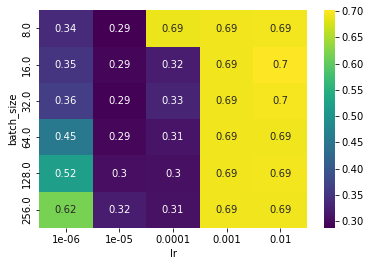

Modelo:  google/bert_uncased_L-4_H-256_A-4


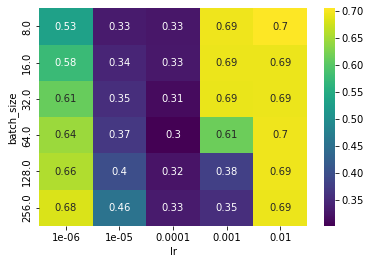

Modelo:  google/bert_uncased_L-2_H-128_A-2


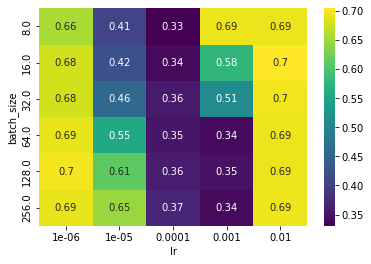

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

for model_name in model_list:
    print("Modelo: ", model_name)

    df = log_df.loc[log_df['model_name'] == model_name]

    df = df[["batch_size", "lr", "val_loss"]]

    sns.heatmap(df.pivot(index='batch_size', columns='lr', values='val_loss'), annot=True, cmap="viridis")
    plt.show()
    plt.close()

### Curvas de loss para os melhores resultados de cada modelo

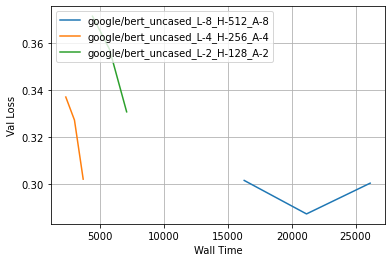

In [13]:
for model_name in model_list:


    idx = log_df.loc[log_df['model_name'] == model_name]["val_loss"].idxmin()

    y = log_df.at[idx, "losses_list"]
    x = log_df.at[idx, "times"]

    plt.plot(x, y, label=model_name)
    plt.legend(loc="upper left")

plt.xlabel('Wall Time')
plt.ylabel('Val Loss')

plt.grid()
plt.savefig("roxo.png")
plt.show()
plt.close()